# **Importando Bibliotecas e iniciando Sessão no Spark**

In [606]:
%pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [607]:
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StringType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [608]:
spark = SparkSession.builder\
.master('local[*]')\
.appName('ClientSatisfaction')\
.getOrCreate()

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Análises Preliminares**

In [609]:
dados = spark.read.csv('/content/drive/MyDrive/.Data Science/Projetos para Portfólio/Santander/Customer Satisfaction/data/train.csv',
                       header=True, inferSchema=True)

In [610]:
dados.count()

76020

In [611]:
len(dados.columns)

371

In [612]:
dados.show(truncate=False)

+---+----+-----+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------+------------------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+-----------+---------+-----------+-----------------+---------------+-----------------+---------------+-----------------+---------------+---------+-----------+---------+-----------+---------+-----------+---------+---------+-----------+---------+-----------+---------+-------------+-----------+-------------+---------+-----------+---------+-----------+-----------+---------+---------+-----------+---------+-----------+---------+-----------+---------+-------------+-----------+---------+-----------+--------

In [613]:
types = []
for tipo in dados.dtypes:
  types.append(tipo[1])
set(types)

{'bigint', 'double', 'int'}

O laço que criei está pegando o **tipo** de cada coluna e colocando em uma lista chamada **type**, depois converto a lista em **set** para remover as duplicatas e descobrir quais são os **tipos** presentes no DataFrame 

In [614]:
dados.show(truncate=False)

+---+----+-----+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------+------------------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+-----------+---------+-----------+-----------------+---------------+-----------------+---------------+-----------------+---------------+---------+-----------+---------+-----------+---------+-----------+---------+---------+-----------+---------+-----------+---------+-------------+-----------+-------------+---------+-----------+---------+-----------+-----------+---------+---------+-----------+---------+-----------+---------+-----------+---------+-------------+-----------+---------+-----------+--------

In [615]:
dados.select('ID').dtypes

[('ID', 'int')]

Há um problema na coluna **ID**, está como ***int***, porém essa coluna é a **chave-primária** e por isso o ideal é que seja uma **string**, por isso irei mudar o tipo dessa coluna.

In [616]:
dados = dados.withColumn('ID', dados['ID'].cast(StringType()))

In [617]:
dados.select('ID').dtypes

[('ID', 'string')]

Agora que formato da coluna **ID** está correto. Irei procurar por dados nulos.

In [618]:
dados.select(sum([f.count(f.when(f.isnan(c)|f.isnull(c), True)).alias(c)for c in dados.columns]).alias('Valores Nulos Totais')).show()

+--------------------+
|Valores Nulos Totais|
+--------------------+
|                   0|
+--------------------+



In [619]:
dados.groupBy('TARGET').count().show()

+------+-----+
|TARGET|count|
+------+-----+
|     1| 3008|
|     0|73012|
+------+-----+



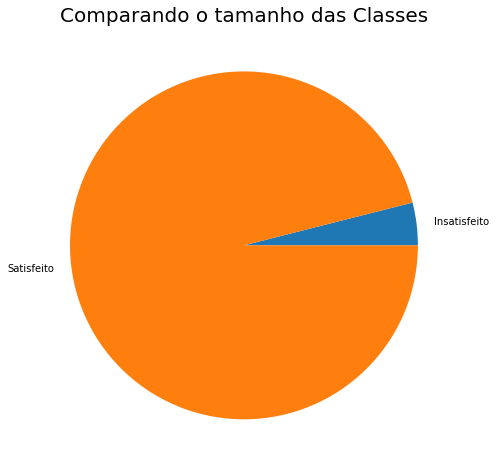

In [620]:
target = [3008, 73012] #Número de elementos da classe 1 e da classe 0 respectivamente
labels = ['Insatisfeito','Satisfeito'] # Nome das classes

ax = plt.figure(figsize=(12,8))
plt.pie(x=target, labels=labels)
plt.title('Comparando o tamanho das Classes', fontsize=20)
ax.show()

# **Preparando os dados para os modelos de Machine Learning**

### Preparando os dados para o modelo

In [621]:
dados = dados.withColumnRenamed('TARGET', 'label')

In [622]:
dados.select('label').count()

76020

## **Tratando o desbalanceamento com weightCol**

Como os classes estão **desbalanceadas**, vou adotar a abordagem de criar uma coluna com o peso das classes.

Os passos são:
1. Descobrir a **quantidade de elementos em cada classe** e o **total**; 
2. Usar a formula (n_total / (n_classes*n_elementos_na_classe)), isso para as duas classes;
3. Criar uma coluna com o valor do peso referente a classe.

In [623]:
dados.select(f.count(f.when(dados['label']==1, True)).alias('n_class_1')).show()

+---------+
|n_class_1|
+---------+
|     3008|
+---------+



In [624]:
dados.select(f.count(f.when(dados['label']==0, True)).alias('n_class_0')).show()

+---------+
|n_class_0|
+---------+
|    73012|
+---------+



In [625]:
Class_0_weight = 76020/(2*73012)
Class_1_weight = 76020/(2*3008)

print(f'O peso da classe 0 é {Class_0_weight} \nO peso da classe 1 é {Class_1_weight}')

O peso da classe 0 é 0.5205993535309265 
O peso da classe 1 é 12.636303191489361


In [626]:
"""
A baixo sobrescrevo o DataFrame dados, adicionando uma coluna com os pessos
"""

dados = dados.select('*',(f.when(dados['label']==0, Class_0_weight).otherwise(Class_1_weight)).alias('ColWeight'))

In [627]:
dados.select('ColWeight').show()

+------------------+
|         ColWeight|
+------------------+
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
|0.5205993535309265|
+------------------+
only showing top 20 rows



In [628]:
dados.agg(f.countDistinct('ColWeight').alias('Valores Distintos')).show()


+-----------------+
|Valores Distintos|
+-----------------+
|                2|
+-----------------+



In [629]:
dados.select('ColWeight').distinct().show()

+------------------+
|         ColWeight|
+------------------+
|0.5205993535309265|
|12.636303191489361|
+------------------+



In [630]:
X = dados.columns
X.remove('label')
X.remove('ID')
X.remove('ColWeight')

In [631]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [632]:
dados_preparados = assembler.transform(dados).select('features', 'label', 'ColWeight')

In [633]:
dados_preparados.show()

+--------------------+-----+------------------+
|            features|label|         ColWeight|
+--------------------+-----+------------------+
|(369,[0,1,23,62,7...|    0|0.5205993535309265|
|(369,[0,1,23,31,3...|    0|0.5205993535309265|
|(369,[0,1,23,24,6...|    0|0.5205993535309265|
|(369,[0,1,3,4,10,...|    0|0.5205993535309265|
|(369,[0,1,23,29,3...|    0|0.5205993535309265|
|(369,[0,1,23,62,7...|    0|0.5205993535309265|
|(369,[0,1,23,24,6...|    0|0.5205993535309265|
|(369,[0,1,23,24,6...|    0|0.5205993535309265|
|(369,[0,1,23,62,7...|    0|0.5205993535309265|
|(369,[0,1,23,24,6...|    0|0.5205993535309265|
|(369,[0,1,27,28,6...|    0|0.5205993535309265|
|(369,[0,1,23,62,7...|    0|0.5205993535309265|
|(369,[0,1,23,24,6...|    0|0.5205993535309265|
|(369,[0,1,23,29,3...|    0|0.5205993535309265|
|(369,[0,1,2,3,4,1...|    0|0.5205993535309265|
|(369,[0,1,23,24,6...|    0|0.5205993535309265|
|(369,[0,1,23,62,8...|    0|0.5205993535309265|
|(369,[0,1,3,4,10,...|    0|0.5205993535

In [634]:
SEED = 101

In [635]:
train, test = dados_preparados.randomSplit([0.7, 0.3], seed=SEED)

In [636]:
train.count()

53147

In [637]:
test.count()

22873

# **Testando Modelos**
Agora chegou o momento de testar modelos de classificação e escolher um com as melhores métricas.

## Criando Funções para métricas

In [638]:
def calcula_mostra_matriz_confusao(df_transform_modelo, normalize=False, percentage=True):
  tp = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 1) & (f.col('prediction') == 1)).count()
  tn = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 0) & (f.col('prediction') == 0)).count()
  fp = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 0) & (f.col('prediction') == 1)).count()
  fn = df_transform_modelo.select('label', 'prediction').where((f.col('label') == 1) & (f.col('prediction') == 0)).count()

  valorP = 1
  valorN = 1

  if normalize:
    valorP = tp + fn
    valorN = fp + tn

  if percentage and normalize:
    valorP = valorP / 100
    valorN = valorN / 100

  print(' '*20, 'Previsto')
  print(' '*15, 'Atrito', ' '*5 ,'Não-Atrito')
  print(' '*4, 'Atrito', ' '*6, int(tp/valorP), ' '*7, int(fn/valorP))
  print('Real')
  print(' '*4, 'Não-Atrito', ' '*2, int(fp/valorN), ' '*7, int(tn/valorN))

In [639]:
def calcula_metricas(nome_modelo, previsao_treino, previsao_teste):
  print('='*50)
  print(nome_modelo)
  print('='*50)
  print('')
  print('-'*50)
  print('Dados de Treino')
  print('-'*50)
  print("Acurácia: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "accuracy", evaluator.weightCol:'ColWeight'}))
  print("Precisão: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "weightedPrecision", evaluator.weightCol:'ColWeight'}))
  print("Recall: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "weightedRecall", evaluator.weightCol:'ColWeight'}))
  print("F1: %f" % evaluator.evaluate(previsao_treino, {evaluator.metricName: "weightedFMeasure", evaluator.weightCol:'ColWeight' }))
  print('='*50)
  print('-'*50)
  print('')
  print('Dados de Teste')
  print('-'*50)
  print("Acurácia: %f" % evaluator.evaluate(previsao_teste, {evaluator.metricName: "accuracy", evaluator.weightCol:'ColWeight'}))
  print("Precisão: %f" % evaluator.evaluate(previsao_teste, {evaluator.metricName: "weightedPrecision", evaluator.weightCol:'ColWeight'}))
  print("Recall: %f" % evaluator.evaluate(previsao_teste, {evaluator.metricName: "weightedRecall", evaluator.weightCol:'ColWeight'}))
  print("F1: %f" % evaluator.evaluate(previsao_teste, {evaluator.metricName: "weightedFMeasure", evaluator.weightCol:'ColWeight' }))
  print('-'*50)
  print('')
  print('Matrix de Confusão')
  print('-'*50)
  calcula_mostra_matriz_confusao(previsao_teste, normalize=False)
  print('='*50)


## LogisticRegression

In [641]:
lr = LogisticRegression(weightCol='ColWeight')

In [642]:
modelo_lr = lr.fit(train)

In [643]:
previsao_modelo_lr_train = modelo_lr.transform(train)
previsao_modelo_lr_test = modelo_lr.transform(test)

In [644]:
previsao_modelo_lr_train.show()

+--------------------+-----+------------------+--------------------+--------------------+----------+
|            features|label|         ColWeight|       rawPrediction|         probability|prediction|
+--------------------+-----+------------------+--------------------+--------------------+----------+
|(369,[0,1,2,3,4,5...|    1|12.636303191489361|[-3.4523842593229...|[0.03069783514312...|       1.0|
|(369,[0,1,2,3,4,5...|    0|0.5205993535309265|[0.77185155406017...|[0.68392128589444...|       0.0|
|(369,[0,1,2,3,4,5...|    0|0.5205993535309265|[-2.7087206632678...|[0.06246072662890...|       1.0|
|(369,[0,1,2,3,4,5...|    0|0.5205993535309265|[-0.2161043241797...|[0.44618319800986...|       1.0|
|(369,[0,1,2,3,4,5...|    0|0.5205993535309265|[0.04124766800793...|[0.51031045521840...|       0.0|
|(369,[0,1,2,3,4,5...|    0|0.5205993535309265|[-0.2661204944923...|[0.43385975475114...|       1.0|
|(369,[0,1,2,3,4,5...|    0|0.5205993535309265|[0.96067448955108...|[0.72325682884427...|  

In [646]:
evaluator = MulticlassClassificationEvaluator()

In [647]:
calcula_metricas('Pontuação LogisticRegression', previsao_modelo_lr_train, previsao_modelo_lr_test)

Pontuação LogisticRegression

--------------------------------------------------
Dados de Treino
--------------------------------------------------
Acurácia: 0.727937
Precisão: 0.729400
Recall: 0.727937
F1: 0.727485
--------------------------------------------------

Dados de Teste
--------------------------------------------------
Acurácia: 0.713880
Precisão: 0.714711
Recall: 0.713880
F1: 0.713637
--------------------------------------------------

Matrix de Confusão
--------------------------------------------------
                     Previsto
                Atrito       Não-Atrito
     Atrito        670         231
Real
     Não-Atrito    6937         15035


## DecisionTreeClassifier

In [649]:
dtc = DecisionTreeClassifier(seed=SEED, weightCol='ColWeight')

In [650]:
modelo_dtc = dtc.fit(train)

In [651]:
previsoes_modelo_dtc_train = modelo_dtc.transform(train)
previsoes_modelo_dtc_test = modelo_dtc.transform(test)

In [652]:
calcula_metricas('Pontuação DecisionTreeClassifier', previsoes_modelo_dtc_train, previsoes_modelo_dtc_test)

Pontuação DecisionTreeClassifier

--------------------------------------------------
Dados de Treino
--------------------------------------------------
Acurácia: 0.759515
Precisão: 0.763306
Recall: 0.759515
F1: 0.758668
--------------------------------------------------

Dados de Teste
--------------------------------------------------
Acurácia: 0.740851
Precisão: 0.745855
Recall: 0.740851
F1: 0.739459
--------------------------------------------------

Matrix de Confusão
--------------------------------------------------
                     Previsto
                Atrito       Não-Atrito
     Atrito        602         299
Real
     Não-Atrito    4104         17868


## Random Forest Classifier

In [654]:
rfc = RandomForestClassifier(seed=SEED, weightCol='ColWeight')

In [655]:
modelo_rfc = rfc.fit(train)

In [656]:
previsao_modelo_rfc_train = modelo_rfc.transform(train)
previsao_modelo_rfc_test = modelo_rfc.transform(test)

In [657]:
calcula_metricas('Pontuação RandomForestClassifier', previsao_modelo_rfc_train, previsao_modelo_rfc_test)

Pontuação RandomForestClassifier

--------------------------------------------------
Dados de Treino
--------------------------------------------------
Acurácia: 0.705178
Precisão: 0.705645
Recall: 0.705178
F1: 0.705022
--------------------------------------------------

Dados de Teste
--------------------------------------------------
Acurácia: 0.699255
Precisão: 0.699712
Recall: 0.699255
F1: 0.699053
--------------------------------------------------

Matrix de Confusão
--------------------------------------------------
                     Previsto
                Atrito       Não-Atrito
     Atrito        607         294
Real
     Não-Atrito    6049         15923


# **Cross Validate**

## Conhecendo os Parâmetros e fazendo o Cross Validator

In [669]:
print(modelo_lr.explainParam('maxIter'))
print(modelo_lr.explainParam('aggregationDepth'))
print(modelo_lr.explainParam('family'))
print(modelo_lr.explainParam('threshold'))
print(modelo_lr.explainParam('fitIntercept'))
print(modelo_lr.explainParam('elasticNetParam'))
print(modelo_lr.explainParam('regParam'))

maxIter: max number of iterations (>= 0). (default: 100)
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
threshold: Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p]. (default: 0.5)
fitIntercept: whether to fit an intercept term. (default: True)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
regParam: regularization parameter (>= 0). (default: 0.0)


In [673]:
"""
Criando o Estimador
"""
lr = LogisticRegression(weightCol='ColWeight')

"""
Criando o mapa de parâmetros
"""
paramns = ParamGridBuilder()\
.addGrid(lr.maxIter, [100, 200, 300])\
.addGrid(lr.aggregationDepth, [2, 4, 6])\
.addGrid(lr.elasticNetParam, [0, 1])\
.build()

"""
Após criar o ParamMaps, crio o evaluator, coloquei o 
ColWeight devido ao desbalanceamento dos dados, além disso 
os dados no momento de treinar os dados passei o ColWeight
"""
evaluator = MulticlassClassificationEvaluator(weightCol='ColWeight')

"""
Então crio o CrossValidator, passando o estimador LogisticRegression,
o mapa de parâmetros, o evaluator, peço para quebrar em 5 partes, e passo a seed
que defini no começo do notebook, 'SEED=101'
"""
cv = CrossValidator(estimator=lr, 
               estimatorParamMaps=paramns,
               evaluator = evaluator,
               numFolds=5,
               seed=SEED)

modelo_final = cv.fit(train)


In [674]:
previsoes_modelo_final_treino = modelo_final.transform(train)
previsoes_modelo_final_teste = modelo_final.transform(test)

calcula_metricas('LogisticRegression com CrossValidator',
                 previsoes_modelo_final_treino,
                 previsoes_modelo_final_teste)

LogisticRegression com CrossValidator

--------------------------------------------------
Dados de Treino
--------------------------------------------------
Acurácia: 0.727188
Precisão: 0.728631
Recall: 0.727188
F1: 0.726739
--------------------------------------------------

Dados de Teste
--------------------------------------------------
Acurácia: 0.714137
Precisão: 0.715015
Recall: 0.714137
F1: 0.713879
--------------------------------------------------

Matrix de Confusão
--------------------------------------------------
                     Previsto
                Atrito       Não-Atrito
     Atrito        671         230
Real
     Não-Atrito    6950         15022


## Construindo o modelo final, e prevendo a satisfação do cliento no arquivo de teste

In [688]:
melhor_modelo = modelo_final.bestModel

print(f'O MaxIter foi {melhor_modelo.getMaxIter()}')
print(f'O aggregationDepth foi {melhor_modelo.getAggregationDepth()}')
print(f'O ElasticNetParam ideal foi {melhor_modelo.getElasticNetParam()}')

O MaxIter foi 200
O aggregationDepth foi 2
O ElasticNetParam ideal foi 0.0


In [690]:
lr = LogisticRegression(weightCol='ColWeight', maxIter=200, aggregationDepth=2, elasticNetParam=0)
modelo = lr.fit(dados_preparados)

In [704]:
dados_teste = spark.read.csv('/content/drive/MyDrive/.Data Science/Projetos para Portfólio/Santander/Customer Satisfaction/data/test.csv', header=True, inferSchema=True)

In [705]:
dados_teste.show(5)

+---+----+-----+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------+------------------+----------+--------+----------+--------+----------+--------+----------+--------+----------+--------+-----------+---------+-----------+-----------------+---------------+-----------------+---------------+-----------------+---------------+---------+-----------+---------+-----------+---------+-----------+---------+---------+-----------+---------+-----------+---------+-------------+-----------+-------------+---------+-----------+---------+-----------+-----------+---------+---------+-----------+---------+-----------+---------+-----------+---------+-------------+-----------+---------+-----------+--------

In [708]:
dados_teste_preparados = assembler.transform(dados_teste).select('features')

In [709]:
dados_teste_preparados.show()

+--------------------+
|            features|
+--------------------+
|(369,[0,1,23,24,6...|
|(369,[0,1,23,24,6...|
|(369,[0,1,12,13,1...|
|(369,[0,1,23,62,7...|
|(369,[0,1,23,24,6...|
|(369,[0,1,23,62,7...|
|(369,[0,1,2,3,4,1...|
|(369,[0,1,23,62,8...|
|(369,[0,1,23,24,2...|
|(369,[0,1,23,24,6...|
|(369,[0,1,23,24,6...|
|(369,[0,1,23,24,6...|
|(369,[0,1,3,4,10,...|
|(369,[0,1,23,24,6...|
|(369,[0,1,23,24,3...|
|(369,[0,1,2,3,4,1...|
|(369,[0,1,4,11,23...|
|(369,[0,1,23,24,6...|
|(369,[0,1,23,24,6...|
|(369,[0,1,23,24,6...|
+--------------------+
only showing top 20 rows



In [711]:
previsoes = modelo.transform(dados_teste_preparados)

In [712]:
previsoes.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(369,[0,1,23,24,6...|[0.74882582411419...|[0.67892279831918...|       0.0|
|(369,[0,1,23,24,6...|[0.38030958123482...|[0.59394776799317...|       0.0|
|(369,[0,1,12,13,1...|[1.37235482439692...|[0.79776034446177...|       0.0|
|(369,[0,1,23,62,7...|[-0.0717594623359...|[0.48206782877975...|       1.0|
|(369,[0,1,23,24,6...|[1.39510911614290...|[0.80140663196091...|       0.0|
|(369,[0,1,23,62,7...|[-1.3359810463355...|[0.20817175095055...|       1.0|
|(369,[0,1,2,3,4,1...|[16.0567861169542...|[0.99999989367721...|       0.0|
|(369,[0,1,23,62,8...|[-0.6871609587531...|[0.33466492940774...|       1.0|
|(369,[0,1,23,24,2...|[-0.7005844159347...|[0.33168266803407...|       1.0|
|(369,[0,1,23,24,6...|[0.00479141294039...|[0.50119785094344...|       0.0|
|(369,[0,1,2